# Vehicle Fit/Predict Pytorch CNN (Optimizes the entire model.)

The train folder and test folder are separated. The former is used to fit the model, and the latter is used to predict. The stage=Test setting has been added in ImageDataset and DataModule.

In [1]:
import os
import random
import pandas as pd
import torch
from torchvision import transforms 
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Use CPU
    print("Using CPU")
    

Using GPU: NVIDIA GeForce GTX 1650



# use train folder for train/valid, use val folder for test

In [2]:
train_dir='vehicleClass/train/'
val_dir='vehicleClass/val/'
test_dir='vehicleClass/test'

In [3]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        classes+=[dirname.split('/')[-1]]
        paths+=[(os.path.join(dirname, filename))]
        
tclasses=[]
tpaths=[]
for dirname, _, filenames in os.walk(val_dir):
    for filename in filenames:
        tclasses+=[dirname.split('/')[-1]]
        tpaths+=[(os.path.join(dirname, filename))]

In [4]:
#Creating Class Name Mappings
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

#Creating DataFrames with Paths, Classes, and Labels
data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)

tdata=pd.DataFrame(columns=['path','class','label'])
tdata['path']=tpaths
tdata['class']=tclasses
tdata['label']=tdata['class'].map(normal_mapping)

['SUV', 'bus', 'family sedan', 'fire engine', 'heavy truck', 'jeep', 'minibus', 'racing car', 'taxi', 'truck']


In [5]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

Displaying Sample Images from the Training Dataset:


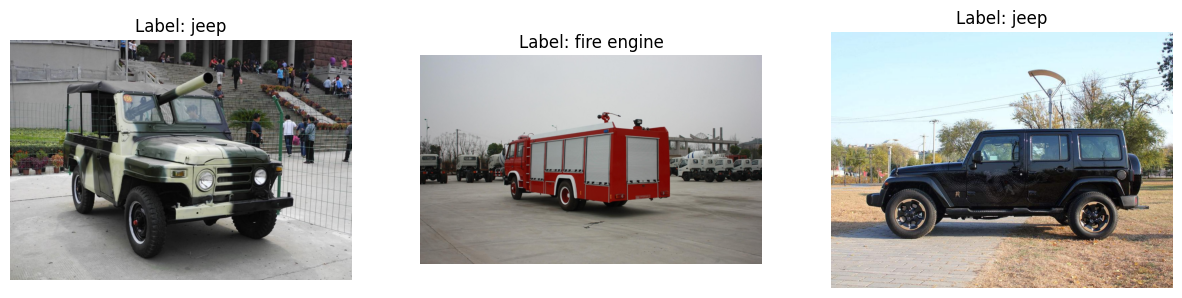

Displaying Sample Images from the Validation Dataset:


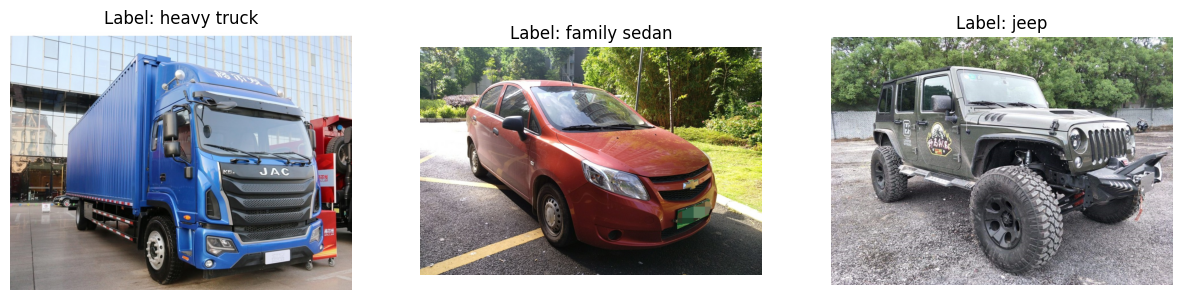

In [6]:
# Function to load image paths and assign labels based on folder names
def load_dataset_from_directory(directory):
    data = []
    for label, folder in enumerate(sorted(os.listdir(directory))):  # Sort to ensure consistent labeling
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
                    data.append({'path': img_path, 'label': folder})  # Use folder name as the label
    return pd.DataFrame(data)

# Function to create path-label list from DataFrame
def create_path_label_list(df):
    path_label_list = [(row['path'], row['label']) for _, row in df.iterrows()]
    return path_label_list

# Function to display images with labels
def display_images_with_labels(path_label_list, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, (path, label) in enumerate(path_label_list[:num_images]):
        try:
            img = Image.open(path)  # Load image using PIL
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {label}")
            axes[i].axis('off')  # Hide axis

        except Exception as e:
            print(f"Error loading image {path}: {e}")
    
    plt.show()

train_data = load_dataset_from_directory(train_dir)
val_data = load_dataset_from_directory(val_dir)

# Shuffle the datasets
path_label_train = random.sample(create_path_label_list(train_data), len(train_data))
path_label_val = random.sample(create_path_label_list(val_data), len(val_data))

# Display some sample images from the training dataset
print("Displaying Sample Images from the Training Dataset:")
display_images_with_labels(path_label_train, num_images=3)

# Display some sample images from the validation dataset (optional)
print("Displaying Sample Images from the Validation Dataset:")
display_images_with_labels(path_label_val, num_images=3)


Displaying Original and Preprocessed Images from the Training Dataset:


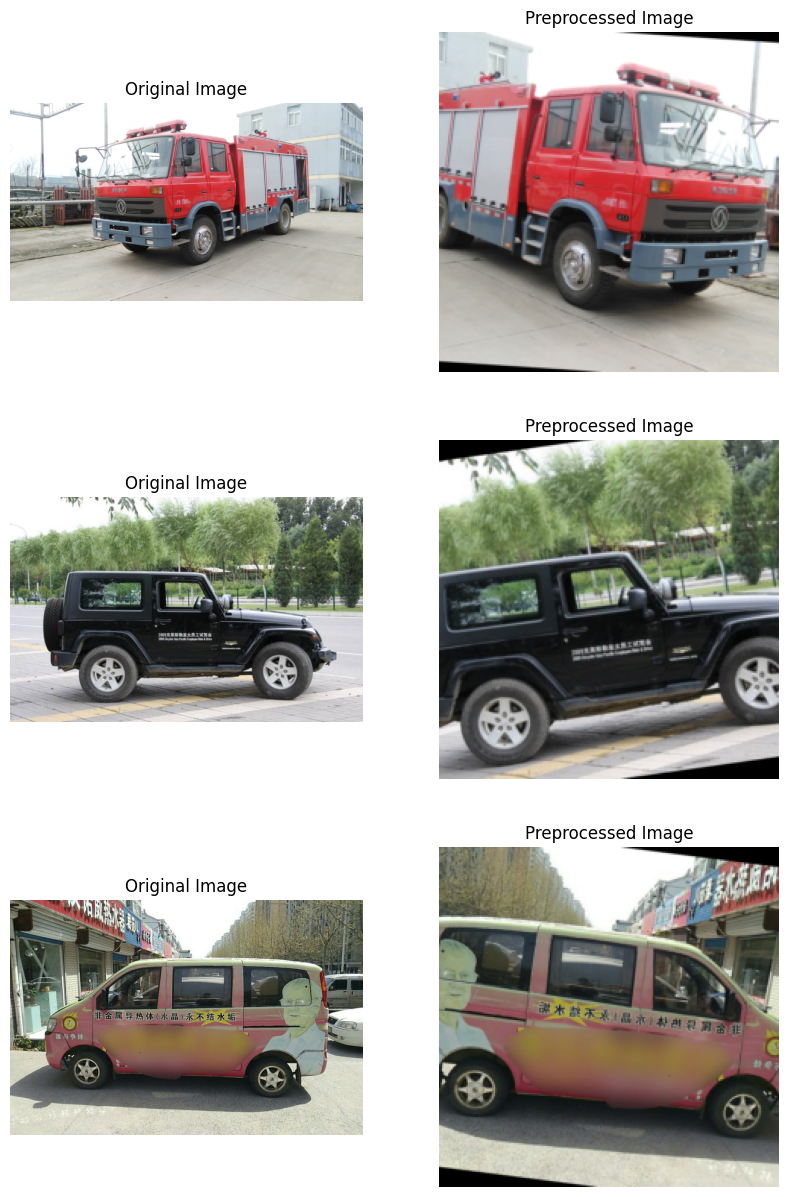

Displaying Original and Preprocessed Images from the Validation Dataset:


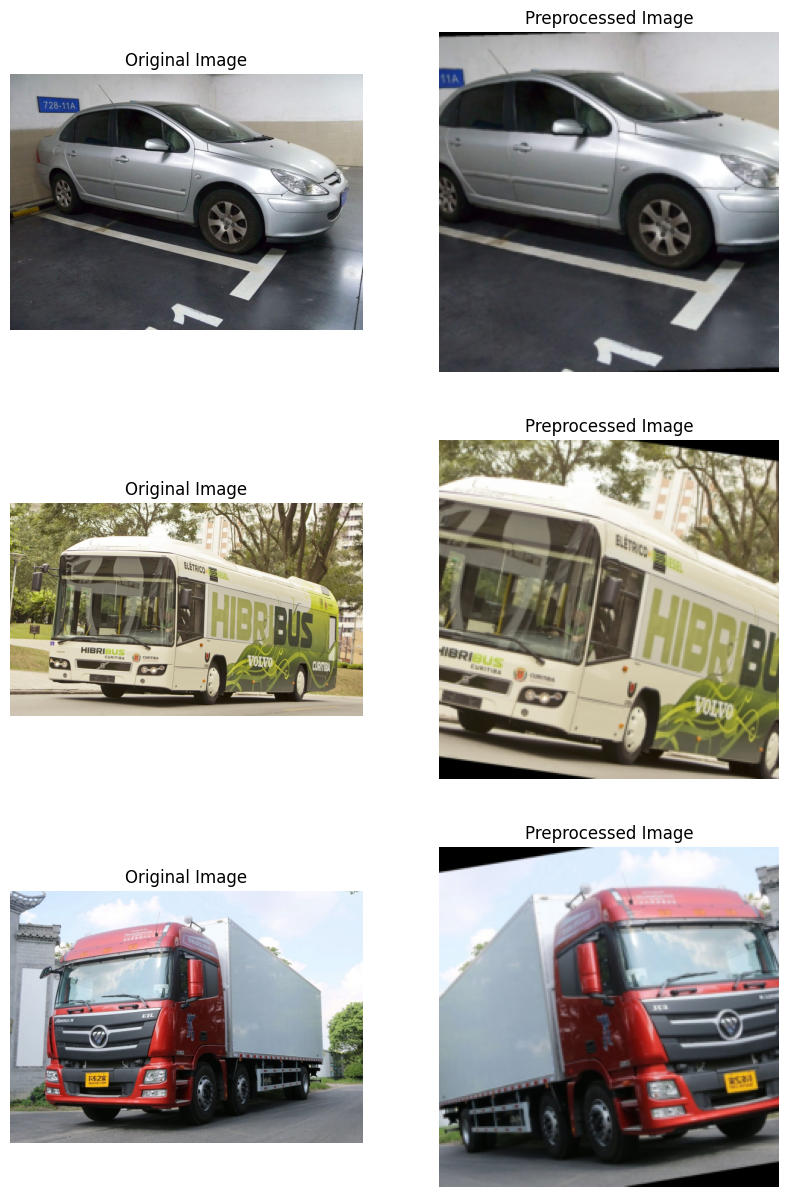

In [7]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Define the normalization values (used in your transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to denormalize the image for visualization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize each channel
    return tensor

# Function to display images before and after transformations
def display_images(image_paths, transform):
    num_images = len(image_paths)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    
    for i, original_image_path in enumerate(image_paths):
        original_img = Image.open(original_image_path).convert("RGB")  # Load original image

        # Apply the transformations
        tensor_img = transform(original_img)
        
        # Denormalize for display
        denorm_img = denormalize(tensor_img.clone(), mean, std)  # Clone to avoid modifying original tensor

        # Convert tensors to numpy arrays for display
        np_original = np.array(original_img)  # Original image as numpy array
        np_preprocessed = denorm_img.permute(1, 2, 0).numpy()  # Rearrange dimensions (C, H, W) -> (H, W, C)

        # Display original image
        axes[i, 0].imshow(np_original)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')  # Hide axis

        # Display preprocessed image
        axes[i, 1].imshow(np_preprocessed)
        axes[i, 1].set_title("Preprocessed Image")
        axes[i, 1].axis('off')  # Hide axis

    plt.show()

# Function to load dataset from directory
def load_dataset_from_directory(directory):
    data = []
    for label, folder in enumerate(sorted(os.listdir(directory))):  # Sort to ensure consistent labeling
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
                    data.append({'path': img_path, 'label': folder})  # Use folder name as the label
    return pd.DataFrame(data)

# Load train data
train_data = load_dataset_from_directory(train_dir)

# Shuffle the training dataset
path_label_train = random.sample(list(zip(train_data['path'], train_data['label'])), len(train_data))

# Select 3 random image paths from the training dataset
random_image_paths = [random.choice(path_label_train)[0] for _ in range(3)]  # Get the paths of 3 random images

# Display the original and preprocessed images
print("Displaying Original and Preprocessed Images from the Training Dataset:")
display_images(random_image_paths, transform)

# Optionally, do the same for the validation dataset if needed
# Load val data
val_data = load_dataset_from_directory(val_dir)

# Shuffle the validation dataset
path_label_val = random.sample(list(zip(val_data['path'], val_data['label'])), len(val_data))

# Select 3 random image paths from the validation dataset
random_val_image_paths = [random.choice(path_label_val)[0] for _ in range(3)]  # Get the paths of 3 random images

# Display the original and preprocessed images from validation dataset
print("Displaying Original and Preprocessed Images from the Validation Dataset:")
display_images(random_val_image_paths, transform)


Transfer Learning Using Resnet50

In [8]:
from torchvision import transforms, datasets
# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [9]:
EPOCHS = 20
LR = 0.1
BATCH = 64
IM_SIZE= 224
STEP = 5
GAMMA = 0.2
DECAY = 0.9

In [10]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match class count
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)


c:\Users\user10\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user10\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=GAMMA, step_size=STEP)

In [12]:
import os
from copy import deepcopy

best_model = deepcopy(model)
best_acc = 0.0

# Initialize lists to store accuracies and losses
acc_train = []
acc_val = []
loss_train = []
loss_val = []

# Define DataFrame to hold the results
results = []

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for data, label in train_loader:
        optimizer.zero_grad()
        data, label = data.to(device), label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        train_loss += loss.item()
        
        _, preds = torch.max(output, 1)
        train_correct += (preds == label).sum().item()
        train_total += label.size(0)
        
        loss.backward()
        optimizer.step()

    train_loss /= train_total
    train_acc = train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            val_loss += loss.item()
            
            _, preds = torch.max(output, 1)
            val_correct += (preds == label).sum().item()
            val_total += label.size(0)
            
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    # Track training and validation accuracy/loss
    acc_train.append(train_acc)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    loss_val.append(val_loss)

    # Append results for this epoch to the results list
    results.append({
        'Epoch': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_acc,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_acc
    })
    
    # Track the best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = deepcopy(model)
    
    # Print progress for the current epoch
    print(f"Epoch {epoch}/{EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Step the scheduler
    scheduler.step()

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Function to determine the next available filename
def get_next_filename(base_filename='training_results', extension='csv'):
    i = 1
    while True:
        filename = f"{base_filename}_{i}.{extension}"
        if not os.path.exists(filename):
            return filename
        i += 1

# Generate the new filename
new_filename = get_next_filename()

# Save results to CSV
results_df.to_csv(new_filename, index=False)

print(f"Training results saved to {new_filename}")
print("Training complete. Best Validation Accuracy:", best_acc)


Epoch 1/20, Train Loss: 0.0962, Train Acc: 0.2964, Val Loss: 0.0355, Val Acc: 0.6000
Epoch 2/20, Train Loss: 0.0188, Train Acc: 0.7000, Val Loss: 0.0482, Val Acc: 0.5900
Epoch 3/20, Train Loss: 0.0146, Train Acc: 0.7629, Val Loss: 0.0095, Val Acc: 0.8750
Epoch 4/20, Train Loss: 0.0057, Train Acc: 0.8821, Val Loss: 0.0143, Val Acc: 0.7150
Epoch 5/20, Train Loss: 0.0096, Train Acc: 0.8271, Val Loss: 0.0206, Val Acc: 0.7800
Epoch 6/20, Train Loss: 0.0040, Train Acc: 0.9136, Val Loss: 0.0058, Val Acc: 0.9100
Epoch 7/20, Train Loss: 0.0035, Train Acc: 0.9279, Val Loss: 0.0061, Val Acc: 0.9150
Epoch 8/20, Train Loss: 0.0034, Train Acc: 0.9307, Val Loss: 0.0051, Val Acc: 0.9350
Epoch 9/20, Train Loss: 0.0033, Train Acc: 0.9386, Val Loss: 0.0059, Val Acc: 0.9200
Epoch 10/20, Train Loss: 0.0033, Train Acc: 0.9314, Val Loss: 0.0051, Val Acc: 0.9100
Epoch 11/20, Train Loss: 0.0032, Train Acc: 0.9407, Val Loss: 0.0043, Val Acc: 0.9150
Epoch 12/20, Train Loss: 0.0033, Train Acc: 0.9321, Val Loss: 0

In [13]:
# Define your model saving directory
model_save_dir = 'C:/Dataset/vehicleClass/models/'

# Create the directory if it doesn't exist
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Save the best model after training
model_save_path = os.path.join(model_save_dir, 'best_model.pth')
torch.save(best_model.state_dict(), model_save_path)

print(f"Best model saved at: {model_save_path}")

Best model saved at: C:/Dataset/vehicleClass/models/best_model.pth


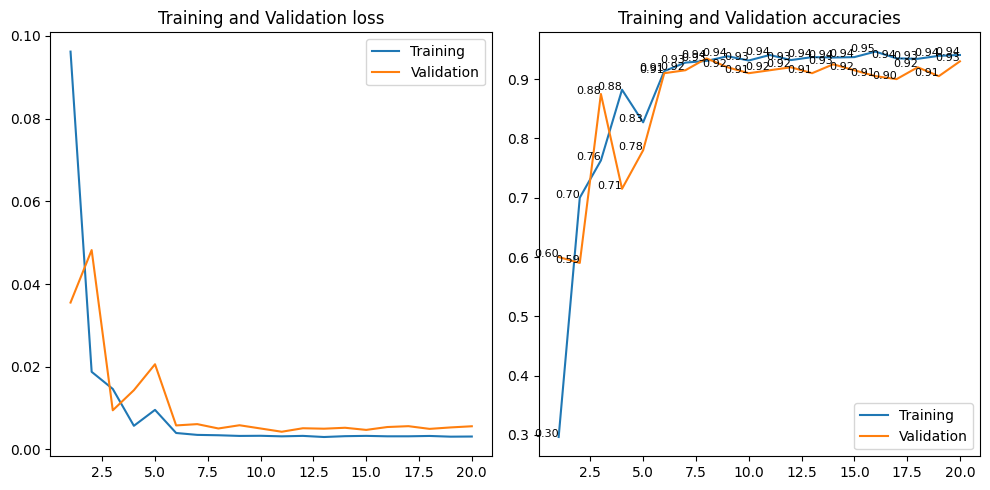

In [14]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(epochs, loss_train)
axes[0].plot(epochs, loss_val)
axes[0].set_title("Training and Validation loss")
axes[0].legend(["Training", "Validation"])
axes[1].plot(epochs, acc_train)
axes[1].plot(epochs, acc_val)
axes[1].set_title("Training and Validation accuracies")
axes[1].legend(["Training", "Validation"])
# Add text annotations for training accuracy
for i, acc in enumerate(acc_train):
    axes[1].text(epochs[i], acc, f"{acc:.2f}", fontsize=8, ha='right')

# Add text annotations for validation accuracy
for i, acc in enumerate(acc_val):
    axes[1].text(epochs[i], acc, f"{acc:.2f}", fontsize=8, ha='right')
    
plt.tight_layout()    
plt.show()

Validation datasets

C:\Users\user10\AppData\Local\Temp\ipykernel_26376\1781766951.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


Model Prediction Accuracy: 91.50%


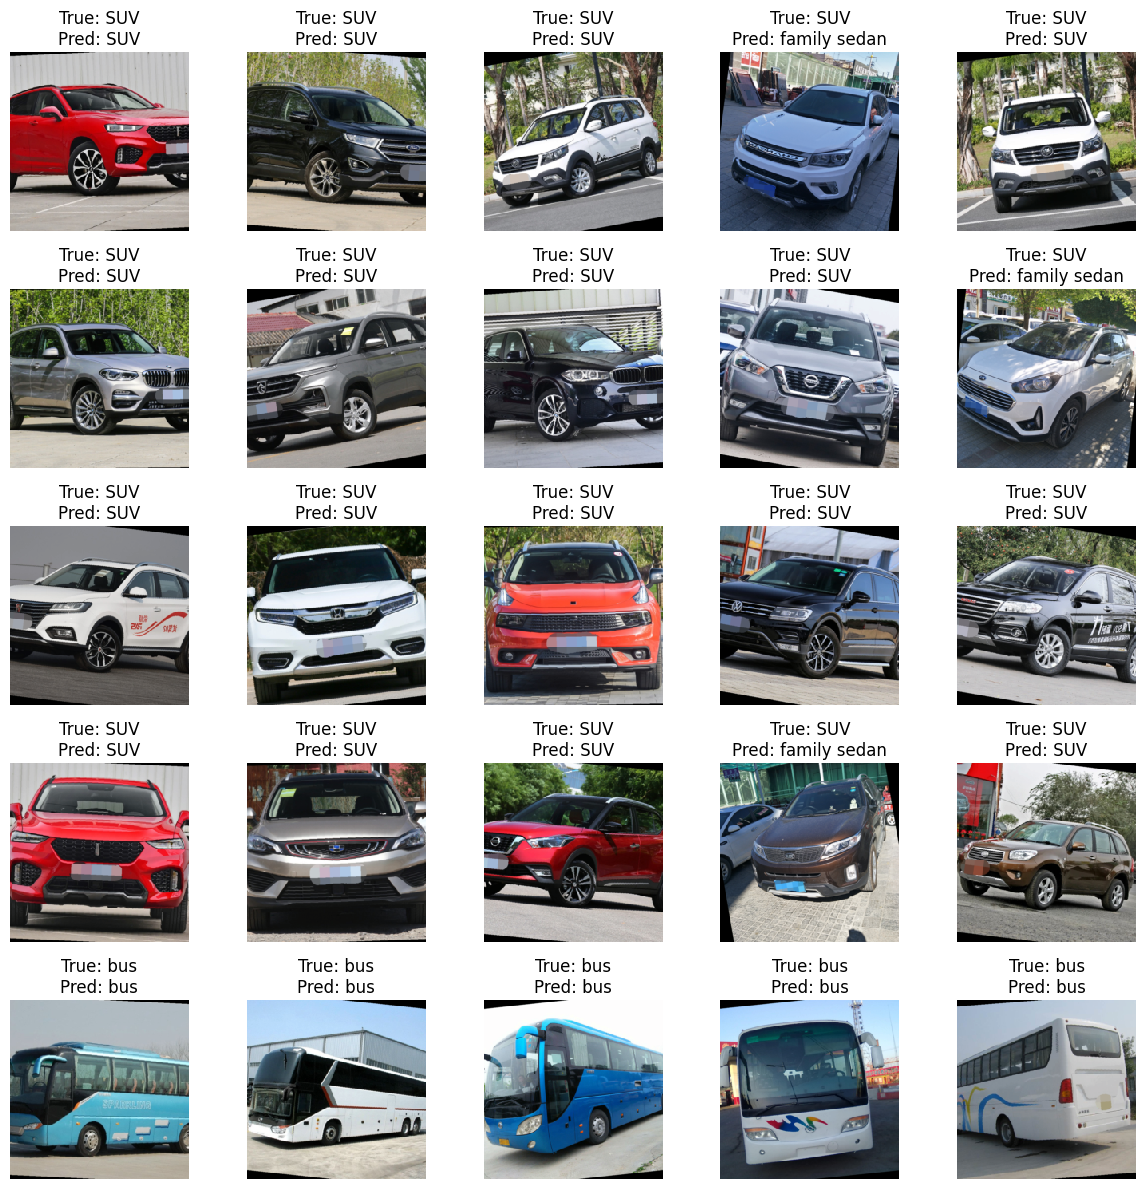

In [19]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Load the best model
best_model_path = 'vehicleClass/models/best_model.pth'
best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.to(device)
best_model.eval()

# Store predicted and expected labels for comparison
predicted_labels = []
expected_labels = []

# Class names (from val_dataset)
class_names = val_dataset.classes  # Use the class names from the dataset

# Predict and collect labels for accuracy calculation
correct = 0
total = 0

for data, labels in val_loader:
    data, labels = data.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        output = best_model(data)
        _, preds = torch.max(output, 1)  # Get the predicted labels

    # Store expected and predicted labels for each item in the batch
    expected_labels.extend([class_names[label.item()] for label in labels])
    predicted_labels.extend([class_names[pred.item()] for pred in preds])

    # Calculate accuracy for this batch
    correct += (preds == labels).sum().item()
    total += labels.size(0)

# Calculate overall accuracy
accuracy = correct / total * 100
print(f"Model Prediction Accuracy: {accuracy:.2f}%")

# Display a few predictions with their true and predicted labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
index = 0

for i in range(5):
    for j in range(5):
        if index >= len(val_loader.dataset):
            break

        # Get the corresponding image and display it
        img, _ = val_loader.dataset[index]
        
        unnormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)
        img = unnormalize(img)  # Reverse the normalization
        img = torch.clamp(img, 0, 1)  # Ensure values are in [0, 1]
        im = transforms.ToPILImage()(img)  # Convert tensor back to PIL Image

        # Display the image with prediction and ground truth labels
        axes[i][j].imshow(im,interpolation='nearest')
        axes[i][j].set_title(f"True: {expected_labels[index]}\nPred: {predicted_labels[index]}")
        axes[i][j].axis('off')
        index += 1

plt.tight_layout()
plt.show()


Testing Dataset

C:\Users\user10\AppData\Local\Temp\ipykernel_26376\61738046.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


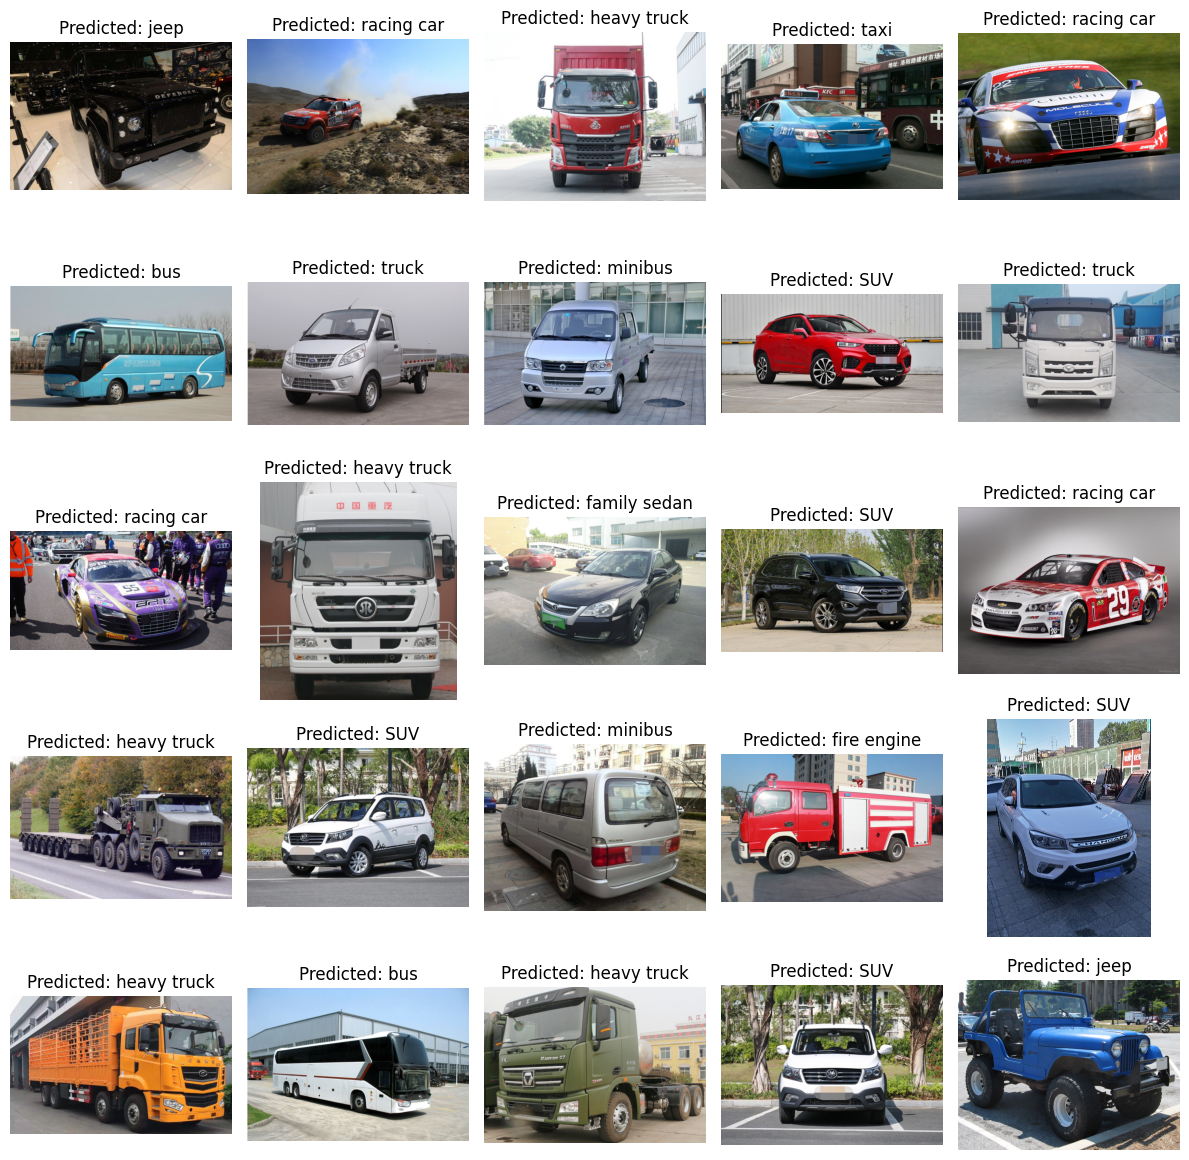

In [15]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define test data directory
test_dir = 'C:/Dataset/vehicleClass/test/'

# Load the best_model (if saved)
best_model_path = 'C:/Dataset/vehicleClass/models/best_model.pth'  # Re-instantiate your model
best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.to(device)
best_model.eval()

# List all images in the test directory
test_image_paths = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir) 
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Prepare to store predictions and images
predicted_labels = []

# Make predictions on the test dataset
for img_path in test_image_paths:
    # Load and transform the image
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # Make prediction
    with torch.no_grad():
        output = best_model(img_tensor)
        _, pred = torch.max(output, 1)
        predicted_labels.append(class_names[pred.item()])  # Store the predicted class name

# Display images with predicted labels
index = 0
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))

for i in range(5):
    for j in range(5):
        if index >= len(test_image_paths):
            break
        im = Image.open(test_image_paths[index])  # Load the image using its path
        axes[i][j].imshow(im)
        axes[i][j].set_title(f"Predicted: {predicted_labels[index]}")
        axes[i][j].axis('off')
        index += 1

plt.tight_layout()
plt.show()


Fine-tuning